In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from style_utils import load_vgg_model, load_and_preprocess_images, GramMatrix, weighted_style_correlation
from glob import glob
import sys
from unittest.mock import MagicMock
sys.modules['napari'] = MagicMock()
sys.modules['napari.utils'] = MagicMock()


from util_micro_sam import run_automatic_instance_segmentation, get_paths
from util_cellpose import run_cellpose_segmentation_single
from tqdm import tqdm
import os
import pandas as pd
from util import get_pred_paths 
from micro_sam.evaluation.evaluation import run_evaluation

/home/idies/workspace/Storage/xyu1/persistent/pytorch_env/micro-sam/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_map = {
    "LiveCELL": "cellpose_livecell",
    "TissueNet": "micro_sam_TissueNet",
    "PlantSeg": "micro_sam_plantseg",
    "Lizard": "cellpose_lizard"
}

# Constants
model_path = "/home/idies/workspace/Storage/xyu1/persistent/micro-sam/finetuning/PytorchNeuralStyleTransfer/Models/vgg_conv.pth"
style_layers = ['r11','r21','r31','r41', 'r51']
style_weights = [1.0] * len(style_layers)

# ---------------------------------------------------
# DATASET FOLDERS
# ---------------------------------------------------
dataset_folders = {
    "LiveCELL": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/livecell/val/images",
    },
    "TissueNet": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/tissuenet/slices/multi_chan/val/images",
    },
    "PlantSeg": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/plantseg/root/val/images",
    },
    "Lizard": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/lizard/val/images",
    },
    "Damond": {
        "test": "/home/idies/workspace/Storage/xyu1/persistent/ImcSegmentationPipeline/data/Damond_2019_Pancreas/Images/Damond/test_6089/images/whole_cell"
    }
}

# ---------------------------------------------------
# LOAD VGG MODEL
# ---------------------------------------------------
vgg = load_vgg_model(model_path)

# ---------------------------------------------------
# FEATURE EXTRACTION FUNCTION
# ---------------------------------------------------
def extract_features(image_path):
    img_name = os.path.basename(image_path)
    image_tensor = load_and_preprocess_images(os.path.dirname(image_path) + "/", [img_name])[0]
    features = [GramMatrix()(f).detach() for f in vgg(image_tensor, style_layers)]
    return features

In [2]:
# Combine all VAL images from other datasets
all_val_images = []
all_val_features = []

for dname, paths in dataset_folders.items():
    if dname == "Damond":   # skip Damond
        continue
    val_folder = paths["val"]
    imgs = sorted([
        os.path.join(val_folder, f)
        for f in os.listdir(val_folder)
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
    ])
    all_val_images.extend(imgs)

print("Total VAL images from all datasets:", len(all_val_images))

# Extract features once
all_val_features = [extract_features(vf) for vf in all_val_images]


# ---------------------------------------------------
# LOAD DAMOND TEST IMAGES
# ---------------------------------------------------
damond_test_folder = dataset_folders["Damond"]["test"]

damond_test_images = sorted([
    os.path.join(damond_test_folder, f)
    for f in os.listdir(damond_test_folder)
    if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
])

print(f"\nLoaded Damond test images: {len(damond_test_images)}")

damond_test_features = [extract_features(img) for img in damond_test_images]


# Prepare entire score matrix
num_val = len(all_val_features)
num_test = len(damond_test_features)

unified_scores = np.zeros((num_val, num_test))

for i, vf in enumerate(all_val_features):
    for j, tf in enumerate(damond_test_features):
        unified_scores[i, j] = weighted_style_correlation(vf, tf, style_weights)

Total VAL images from all datasets: 33

Loaded Damond test images: 65


In [3]:
unified_scores.shape

(33, 65)

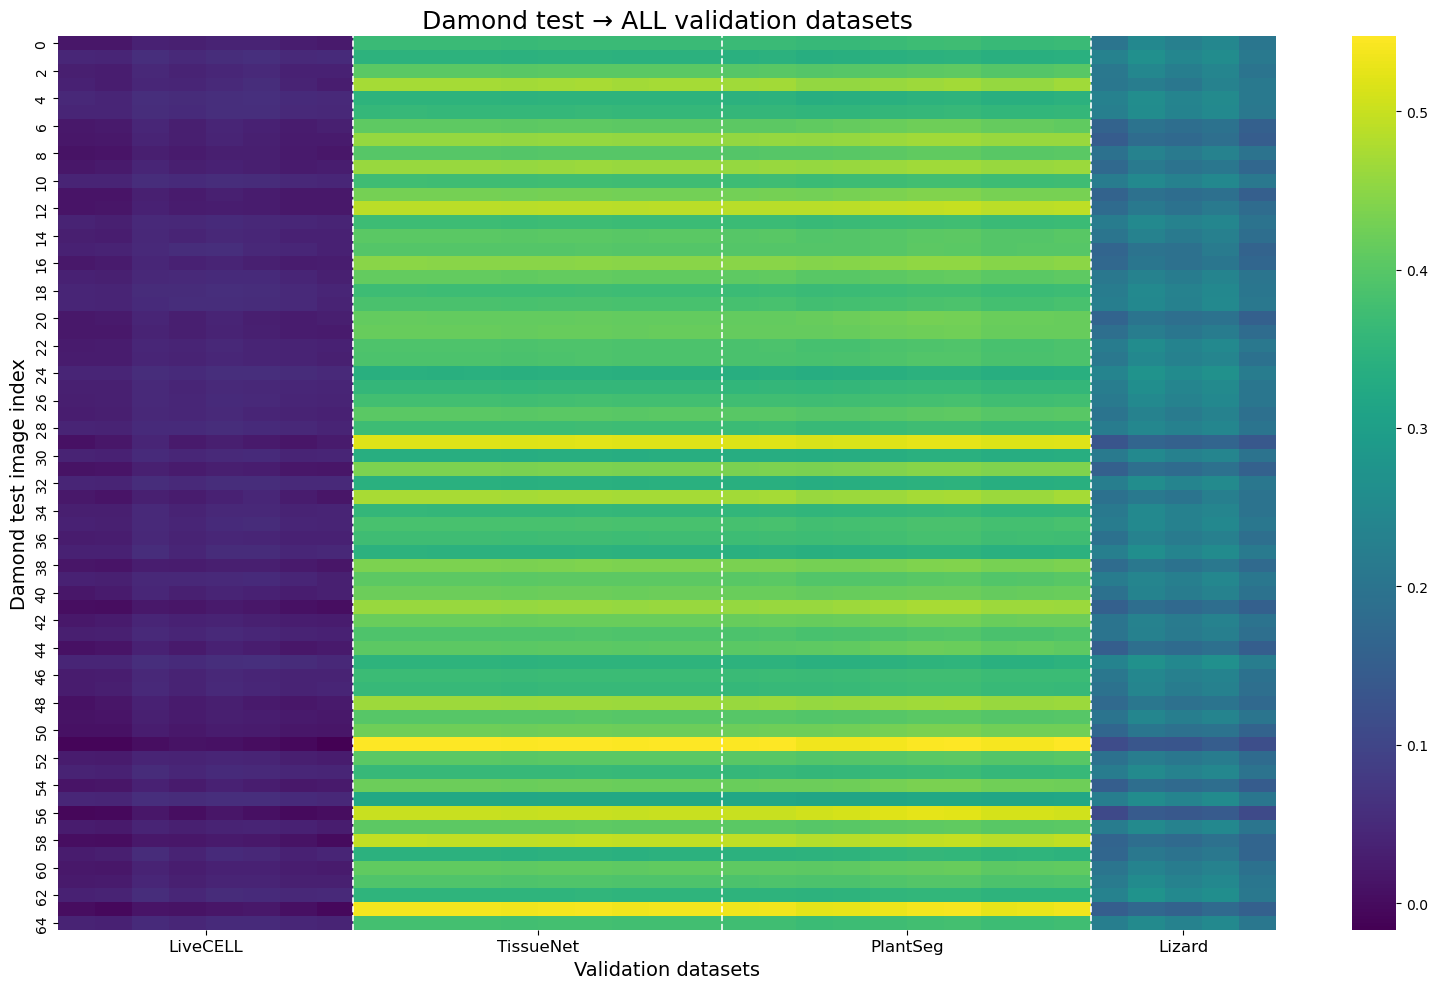

In [4]:
# ------------------------------------------
# Function: draw vertical split lines (X-axis)
# ------------------------------------------
def draw_split_lines(ax, labels):
    """
    Draw vertical dashed lines where dataset label changes.
    labels: list of dataset labels for each X index.
    """
    prev = labels[0]
    for i, label in enumerate(labels):
        if label != prev:
            ax.axvline(i, color='white', linestyle='--', linewidth=1.2)
            prev = label

# ------------------------------------------
# Build all validation images + dataset labels
# ------------------------------------------
all_val_images = []
all_val_dataset_labels = []

for dname, paths in dataset_folders.items():
    if dname == "Damond":   # Damond has only test set
        continue

    val_folder = paths["val"]

    imgs = sorted([
        os.path.join(val_folder, f)
        for f in os.listdir(val_folder)
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
    ])

    all_val_images.extend(imgs)
    all_val_dataset_labels.extend([dname] * len(imgs))

# ------------------------------------------
# Compute dataset block positions for X-axis
# ------------------------------------------
dataset_positions = {}
for i, label in enumerate(all_val_dataset_labels):
    if label not in dataset_positions:
        dataset_positions[label] = [i, i]
    dataset_positions[label][1] = i

# Compute centers for labeling
tick_positions = []
tick_labels = []

for dataset, (start, end) in dataset_positions.items():
    center = (start + end) / 2
    tick_positions.append(center + 0.5)
    tick_labels.append(dataset)

# ------------------------------------------
# Plot unified heatmap: Damond test vs ALL val images
# ------------------------------------------

num_val = len(all_val_images)
num_test = len(damond_test_images)

plt.figure(figsize=(16, 10))

ax = sns.heatmap(unified_scores.T, cmap="viridis", cbar=True)

plt.title("Damond test → ALL validation datasets", fontsize=18)
plt.xlabel("Validation datasets", fontsize=14)
plt.ylabel("Damond test image index", fontsize=14)

# X-axis labels = dataset names at block centers
plt.xticks(
    ticks=tick_positions,
    labels=tick_labels,
    fontsize=12
)

# Y-axis = Damond test indices
plt.yticks(
    #ticks=np.arange(num_test) + 0.5,
    #labels=np.arange(num_test),
    fontsize=10
)

# Add vertical split lines
draw_split_lines(ax, all_val_dataset_labels)

plt.tight_layout()
plt.show()

In [5]:
import os
import pandas as pd

# ------------------------------------------
# Compute average similarity per dataset
# ------------------------------------------
damond_scores = []

datasets = ["LiveCELL", "TissueNet", "PlantSeg", "Lizard"]

for test_idx, test_image in enumerate(damond_test_images):

    dataset_means = {}

    for dataset in datasets:
        idxs = [i for i, lbl in enumerate(all_val_dataset_labels) if lbl == dataset]
        scores = unified_scores.T[test_idx, idxs]
        dataset_means[dataset] = np.mean(scores)

    damond_scores.append({
        "image_name": os.path.basename(test_image),
        **dataset_means
    })

# Convert to DataFrame
df = pd.DataFrame(damond_scores)

# ------------------------------------------
# Model map + selection
# ------------------------------------------
model_map = {
    "LiveCELL": "cellpose_livecell",
    "TissueNet": "micro_sam_TissueNet",
    "PlantSeg": "micro_sam_plantseg",
    "Lizard": "cellpose_lizard"
}

def select_model(row):
    best_dataset = row[["LiveCELL", "TissueNet", "PlantSeg", "Lizard"]].idxmax()
    return model_map[best_dataset]

df["selected_model"] = df.apply(select_model, axis=1)

# ------------------------------------------
# Save CSV
# ------------------------------------------
output_file = "Damond_model_selection.csv"
df.to_csv(output_file, index=False)

print(f"Model selection saved to: {output_file}")

Model selection saved to: Damond_model_selection.csv


In [2]:

file_search_specs = "*"
raw_dir = os.path.join("/home/idies/workspace/Storage/xyu1/persistent/ImcSegmentationPipeline/data/Damond_2019_Pancreas/Images/Damond/test_6089/images/whole_cell", file_search_specs)
labels_dir = os.path.join("/home/idies/workspace/Storage/xyu1/persistent/ImcSegmentationPipeline/data/Damond_2019_Pancreas/Images/Damond/test_6089/masks/whole_cell", file_search_specs)
    
    
image_paths = sorted(glob(os.path.join(raw_dir)))
mask_path = sorted(glob(os.path.join(labels_dir)))


# get the model selection csv file
#df = pd.read_csv("Damond_model_selection.csv")

In [ ]:


def get_model_for_image(df, image_name):
    row = df[df["image_name"] == image_name]
    if not row.empty:
        return row.iloc[0]["selected_model"]
    else:
        return f"Image '{image_name}' not found in the CSV."

#test our own model selection 
DEFAULT = True
for path in tqdm(image_paths):
    #print(path)
    fname = os.path.basename(path)
    print(fname)
    model_name = get_model_for_image(df,fname)
    print(model_name)
    parts = model_name.split("_")

    if parts[0] == "micro":
        if not DEFAULT:
            if parts[-1] == "livecell":
                run_automatic_instance_segmentation(path, dataset_name="livecell", 
                                                    experiment_root = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all",
                                                    model_type="vit_l_lm",
                                                    results_root= "/home/idies/workspace/Temporary/xyu1/scratch/micro_sam_subset/experiment_dir/Damond_IMC_test")
            elif parts[-1] == "TissueNet":
                run_automatic_instance_segmentation(path, dataset_name="tissuenet", 
                                                    experiment_root = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all",
                                                    model_type="vit_l_lm",
                                                    results_root= "/home/idies/workspace/Temporary/xyu1/scratch/micro_sam_subset/experiment_dir/Damond_IMC_test")
            elif parts[-1] == "plantseg":
                run_automatic_instance_segmentation(path, dataset_name="plantseg", 
                                                    experiment_root = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all",
                                                    model_type="vit_l_lm",
                                                    results_root= "/home/idies/workspace/Temporary/xyu1/scratch/micro_sam_subset/experiment_dir/Damond_IMC_test")
        else:
            run_automatic_instance_segmentation(path, dataset_name=None, 
                                        experiment_root = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all",
                                        model_type="vit_l_lm",
                                        results_root= "/home/idies/workspace/Temporary/xyu1/scratch/micro_sam_subset/experiment_dir/Damond_IMC_test")
    
    elif parts[0] == "cellpose":
        run_cellpose_segmentation_single(path, 
                                         experiment_root = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all",
                                         model_type="cyto2")

In [14]:
experiment_folder = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all"

pred_paths = sorted(glob(os.path.join("/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all/predictions", "*")))
results_path = os.path.join(experiment_folder, "results", "amg_default_1.csv")
results = run_evaluation(mask_path, pred_paths, save_path=results_path)

Evaluate predictions: 100%|██████████| 65/65 [00:07<00:00,  8.53it/s]


In [15]:
results

,mSA,SA50,SA75
0,0.119698,0.375078,0.032002


In [ ]:
mask_path

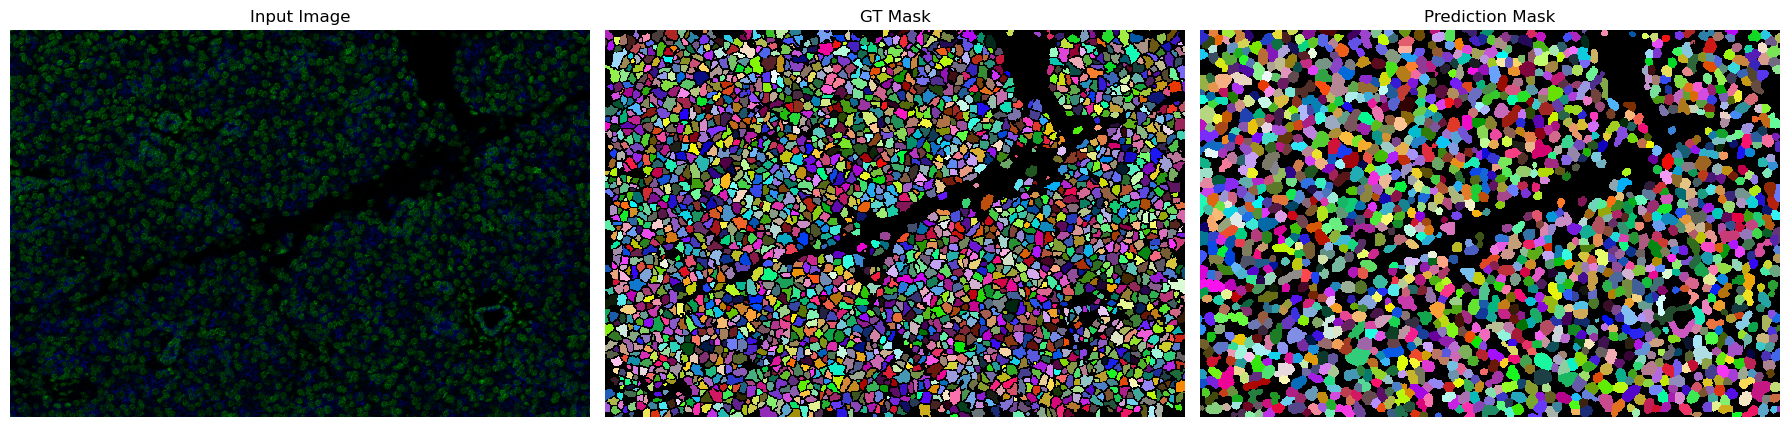

In [15]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# -------------------------------------------------------
# 1. Paths
# -------------------------------------------------------
pred_path = "/home/idies/workspace/Temporary/xyu1/scratch/Damond_IMC_test/Ours_all/predictions/P39_a0_full.tif"
gt_path   = "/home/idies/workspace/Storage/xyu1/persistent/ImcSegmentationPipeline/data/Damond_2019_Pancreas/Images/Damond/test_6089/masks/whole_cell/P39_a0_full_mask.tif"
input_path= "/home/idies/workspace/Storage/xyu1/persistent/ImcSegmentationPipeline/data/Damond_2019_Pancreas/Images/Damond/test_6089/images/whole_cell/P39_a0_full.tif"

# -------------------------------------------------------
# 2. Load images
# -------------------------------------------------------
input_img = tiff.imread(input_path)
gt_mask   = tiff.imread(gt_path)
pred_mask = tiff.imread(pred_path)

# -------------------------------------------------------
# 3. Build per-image consistent color map
# -------------------------------------------------------

# Collect labels only for this image
labels = sorted(set(np.unique(gt_mask)) | set(np.unique(pred_mask)))
num_classes = len(labels)

# Map original labels to 0..N-1
label_to_index = {lab: i for i, lab in enumerate(labels)}

# Random colors (stable)
rng = np.random.default_rng(seed=123)
colors = rng.random((num_classes, 3))

# Force background = black
if 0 in label_to_index:
    colors[label_to_index[0]] = [0, 0, 0]

cmap = ListedColormap(colors)

# Remap masks
gt_remap   = np.vectorize(label_to_index.get)(gt_mask)
pred_remap = np.vectorize(label_to_index.get)(pred_mask)

# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_remap, cmap=cmap, interpolation="nearest")
plt.title("GT Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_remap, cmap=cmap, interpolation="nearest")
plt.title("Prediction Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
